In [1]:
import seaborn as sns
from IPython.display import set_matplotlib_formats
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.patches as mpatches

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix

import pandas as pd

In [2]:
set_matplotlib_formats('retina')
plt.rcParams['figure.dpi'] = 200
plt.rcParams.update({'font.size': 5})
sns.set_style('dark', {'legend.frameon':True})

# NN

In [117]:
# Get the data
def getData(training_dir, train=None, norm_obj=None):
    # preprocessing the data
    training_data = pd.read_csv(training_dir)
    target = training_data['Type'].values
    del training_data['Type']
    training_data = training_data.fillna(0)

    if norm_obj is None:
        ss = StandardScaler()
        training_data = ss.fit_transform(training_data)
    else:
        training_data = norm_obj.transform(training_data)

    Type_map = {'Nan': 0, 'Oil': 1, 'GC': 2, 'Gas': 3}
    training_class = [Type_map[k] for k in target]

    if train:
        X_train, X_val, y_train, y_val = train_test_split(
            training_data, training_class, test_size=0.2, random_state=42, stratify=training_class)
        
        training = data.TensorDataset(torch.FloatTensor(X_train.reshape(-1, 1, X_train.shape[1])),
                                  torch.Tensor(y_train).long())
        training_loader = data.DataLoader(training, batch_size=batch_size, shuffle=True)
        
        validatioin = data.TensorDataset(torch.FloatTensor(X_val.reshape(-1, 1, X_val.shape[1])),
                                  torch.Tensor(y_val).long())
        validatioin_loader = data.DataLoader(validatioin, batch_size=batch_size, shuffle=True)

        class_weight = 1. / torch.unique(torch.Tensor(training_class), return_counts=True)[1].float()
        
        return training_loader, validatioin_loader, class_weight, ss
    else:
        training = data.TensorDataset(torch.FloatTensor(training_data.reshape(-1, 1, training_data.shape[1])),
                                  torch.Tensor(training_class).long())
        training_loader = data.DataLoader(training, batch_size=batch_size, shuffle=True)
        return training_loader


# The network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv1d(1, out_ch, kernel_size=3)
#         self.conv2 = nn.Conv1d(out_ch, out_ch2, kernel_size=3)
        self.pool = nn.MaxPool1d(kernel_size=pool_size)
        self.fc1 = nn.Linear(out_ch*pool_size, L1)
#         self.fc1 = nn.Linear(36, L1)
        self.fc2 = nn.Linear(L1, L2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
#         x = F.relu(self.conv1(x))
#         x = F.relu(self.conv2(x))
        x = x.view(-1, out_ch*pool_size)
#         x = x.view(-1, 36)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
def myTest(test_dataset):
    test_res = []
    test_class = []
    for k, test_data in enumerate(test_dataset, 0):
        test_inputs, test_labels = test_data

        test_res.append(torch.max(net(test_inputs),1)[1])
        test_class.append(test_labels)

    test_pred = torch.cat(test_res)
    test_real = torch.cat(test_class)

    rev_map = {0: 'NaN', 1: 'Oil', 2: 'GC', 3: 'Gas'}
    test_pred2 = [rev_map[i.item()] for i in test_pred]
    test_real2 = [rev_map[i.item()] for i in test_real]
    return test_pred2, test_real2

def plotconfmat(clf, s_pred, y_train):
    clabel = ['NaN','Oil','GC','Gas']
        
    sns.heatmap(confusion_matrix(s_pred, y_train, labels = clabel), xticklabels=clabel, yticklabels=clabel,
                annot=True, cbar = False, cmap="YlGnBu", fmt = 'g')
    plt.title('Confusion matrix of %s, accuracy: %.2f%%, recall: %.2f%%'%(
        clf, accuracy_score(s_pred, y_train)*100, recall_score(s_pred, y_train, average='macro')*100), fontsize = 10)
    plt.xlabel('Lab Measurement', fontsize = 10)
    plt.ylabel('Prediction', fontsize = 10)
    plt.show()

total_loss = []
batch_size = 64
out_ch = 6
out_ch2 = 12
pool_size = 2
L1 = 100
L2 = 4
max_epoch = 500
learning_rate = 1e-3
# training data
training_data, validation_data, class_weight, normalizer = \
    getData(training_dir='C:/YujianWu/Data/AMG/20190624_Flair/nn_training.csv', train=True)

# network
net = Net()

# optimizer
criterion = nn.CrossEntropyLoss(weight=class_weight)
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

# training
for epoch in range(max_epoch):
    running_loss = 0.0
    running_loss_val = 0.0
    for i, _data in enumerate(training_data, 0):
        inputs, labels = _data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
#         if i % 10 == 9:
#             temp_loss = running_loss / 10
#             total_loss.append(temp_loss)
#             print('[%d, %d] loss: %.3f' % (epoch + 1, i + 1, temp_loss))
#             running_loss = 0.0

    # test current net on validation dataset
    for j, val_data in enumerate(validation_data, 0):
        val_inputs, val_labels = val_data
        
        val_outputs = net(val_inputs)
        
        val_loss = criterion(val_outputs, val_labels)
        running_loss_val += val_loss
        
    temp_loss = running_loss / (i + 1)
    temp_loss_val = running_loss_val / (j + 1)
    print('Epoch %d training loss: %.3f, validation loss: %.3f' % (epoch + 1, temp_loss, temp_loss_val))
    total_loss.append([temp_loss, temp_loss_val])

print('Training Finished!')

Epoch 1 training loss: 1.330, validation loss: 1.212
Epoch 2 training loss: 1.169, validation loss: 1.058
Epoch 3 training loss: 1.012, validation loss: 0.938
Epoch 4 training loss: 0.895, validation loss: 0.837
Epoch 5 training loss: 0.798, validation loss: 0.728
Epoch 6 training loss: 0.722, validation loss: 0.687
Epoch 7 training loss: 0.648, validation loss: 0.611
Epoch 8 training loss: 0.556, validation loss: 0.542
Epoch 9 training loss: 0.544, validation loss: 0.525
Epoch 10 training loss: 0.505, validation loss: 0.488
Epoch 11 training loss: 0.451, validation loss: 0.424
Epoch 12 training loss: 0.449, validation loss: 0.439
Epoch 13 training loss: 0.429, validation loss: 0.391
Epoch 14 training loss: 0.377, validation loss: 0.393
Epoch 15 training loss: 0.377, validation loss: 0.344
Epoch 16 training loss: 0.348, validation loss: 0.360
Epoch 17 training loss: 0.334, validation loss: 0.312
Epoch 18 training loss: 0.318, validation loss: 0.353
Epoch 19 training loss: 0.311, valida

Epoch 151 training loss: 0.147, validation loss: 0.170
Epoch 152 training loss: 0.161, validation loss: 0.202
Epoch 153 training loss: 0.162, validation loss: 0.131
Epoch 154 training loss: 0.150, validation loss: 0.154
Epoch 155 training loss: 0.129, validation loss: 0.257
Epoch 156 training loss: 0.147, validation loss: 0.119
Epoch 157 training loss: 0.128, validation loss: 0.196
Epoch 158 training loss: 0.137, validation loss: 0.168
Epoch 159 training loss: 0.136, validation loss: 0.159
Epoch 160 training loss: 0.135, validation loss: 0.189
Epoch 161 training loss: 0.176, validation loss: 0.171
Epoch 162 training loss: 0.132, validation loss: 0.146
Epoch 163 training loss: 0.163, validation loss: 0.208
Epoch 164 training loss: 0.136, validation loss: 0.132
Epoch 165 training loss: 0.139, validation loss: 0.198
Epoch 166 training loss: 0.162, validation loss: 0.123
Epoch 167 training loss: 0.151, validation loss: 0.141
Epoch 168 training loss: 0.141, validation loss: 0.180
Epoch 169 

Epoch 299 training loss: 0.172, validation loss: 0.190
Epoch 300 training loss: 0.121, validation loss: 0.149
Epoch 301 training loss: 0.131, validation loss: 0.158
Epoch 302 training loss: 0.156, validation loss: 0.166
Epoch 303 training loss: 0.120, validation loss: 0.152
Epoch 304 training loss: 0.128, validation loss: 0.224
Epoch 305 training loss: 0.141, validation loss: 0.197
Epoch 306 training loss: 0.147, validation loss: 0.139
Epoch 307 training loss: 0.142, validation loss: 0.142
Epoch 308 training loss: 0.160, validation loss: 0.128
Epoch 309 training loss: 0.135, validation loss: 0.154
Epoch 310 training loss: 0.106, validation loss: 0.148
Epoch 311 training loss: 0.147, validation loss: 0.161
Epoch 312 training loss: 0.121, validation loss: 0.196
Epoch 313 training loss: 0.133, validation loss: 0.147
Epoch 314 training loss: 0.133, validation loss: 0.125
Epoch 315 training loss: 0.128, validation loss: 0.143
Epoch 316 training loss: 0.128, validation loss: 0.148
Epoch 317 

Epoch 447 training loss: 0.107, validation loss: 0.131
Epoch 448 training loss: 0.120, validation loss: 0.156
Epoch 449 training loss: 0.131, validation loss: 0.124
Epoch 450 training loss: 0.136, validation loss: 0.213
Epoch 451 training loss: 0.107, validation loss: 0.218
Epoch 452 training loss: 0.114, validation loss: 0.137
Epoch 453 training loss: 0.127, validation loss: 0.188
Epoch 454 training loss: 0.129, validation loss: 0.152
Epoch 455 training loss: 0.122, validation loss: 0.119
Epoch 456 training loss: 0.104, validation loss: 0.134
Epoch 457 training loss: 0.123, validation loss: 0.163
Epoch 458 training loss: 0.111, validation loss: 0.184
Epoch 459 training loss: 0.106, validation loss: 0.145
Epoch 460 training loss: 0.109, validation loss: 0.208
Epoch 461 training loss: 0.128, validation loss: 0.178
Epoch 462 training loss: 0.093, validation loss: 0.141
Epoch 463 training loss: 0.102, validation loss: 0.156
Epoch 464 training loss: 0.146, validation loss: 0.187
Epoch 465 

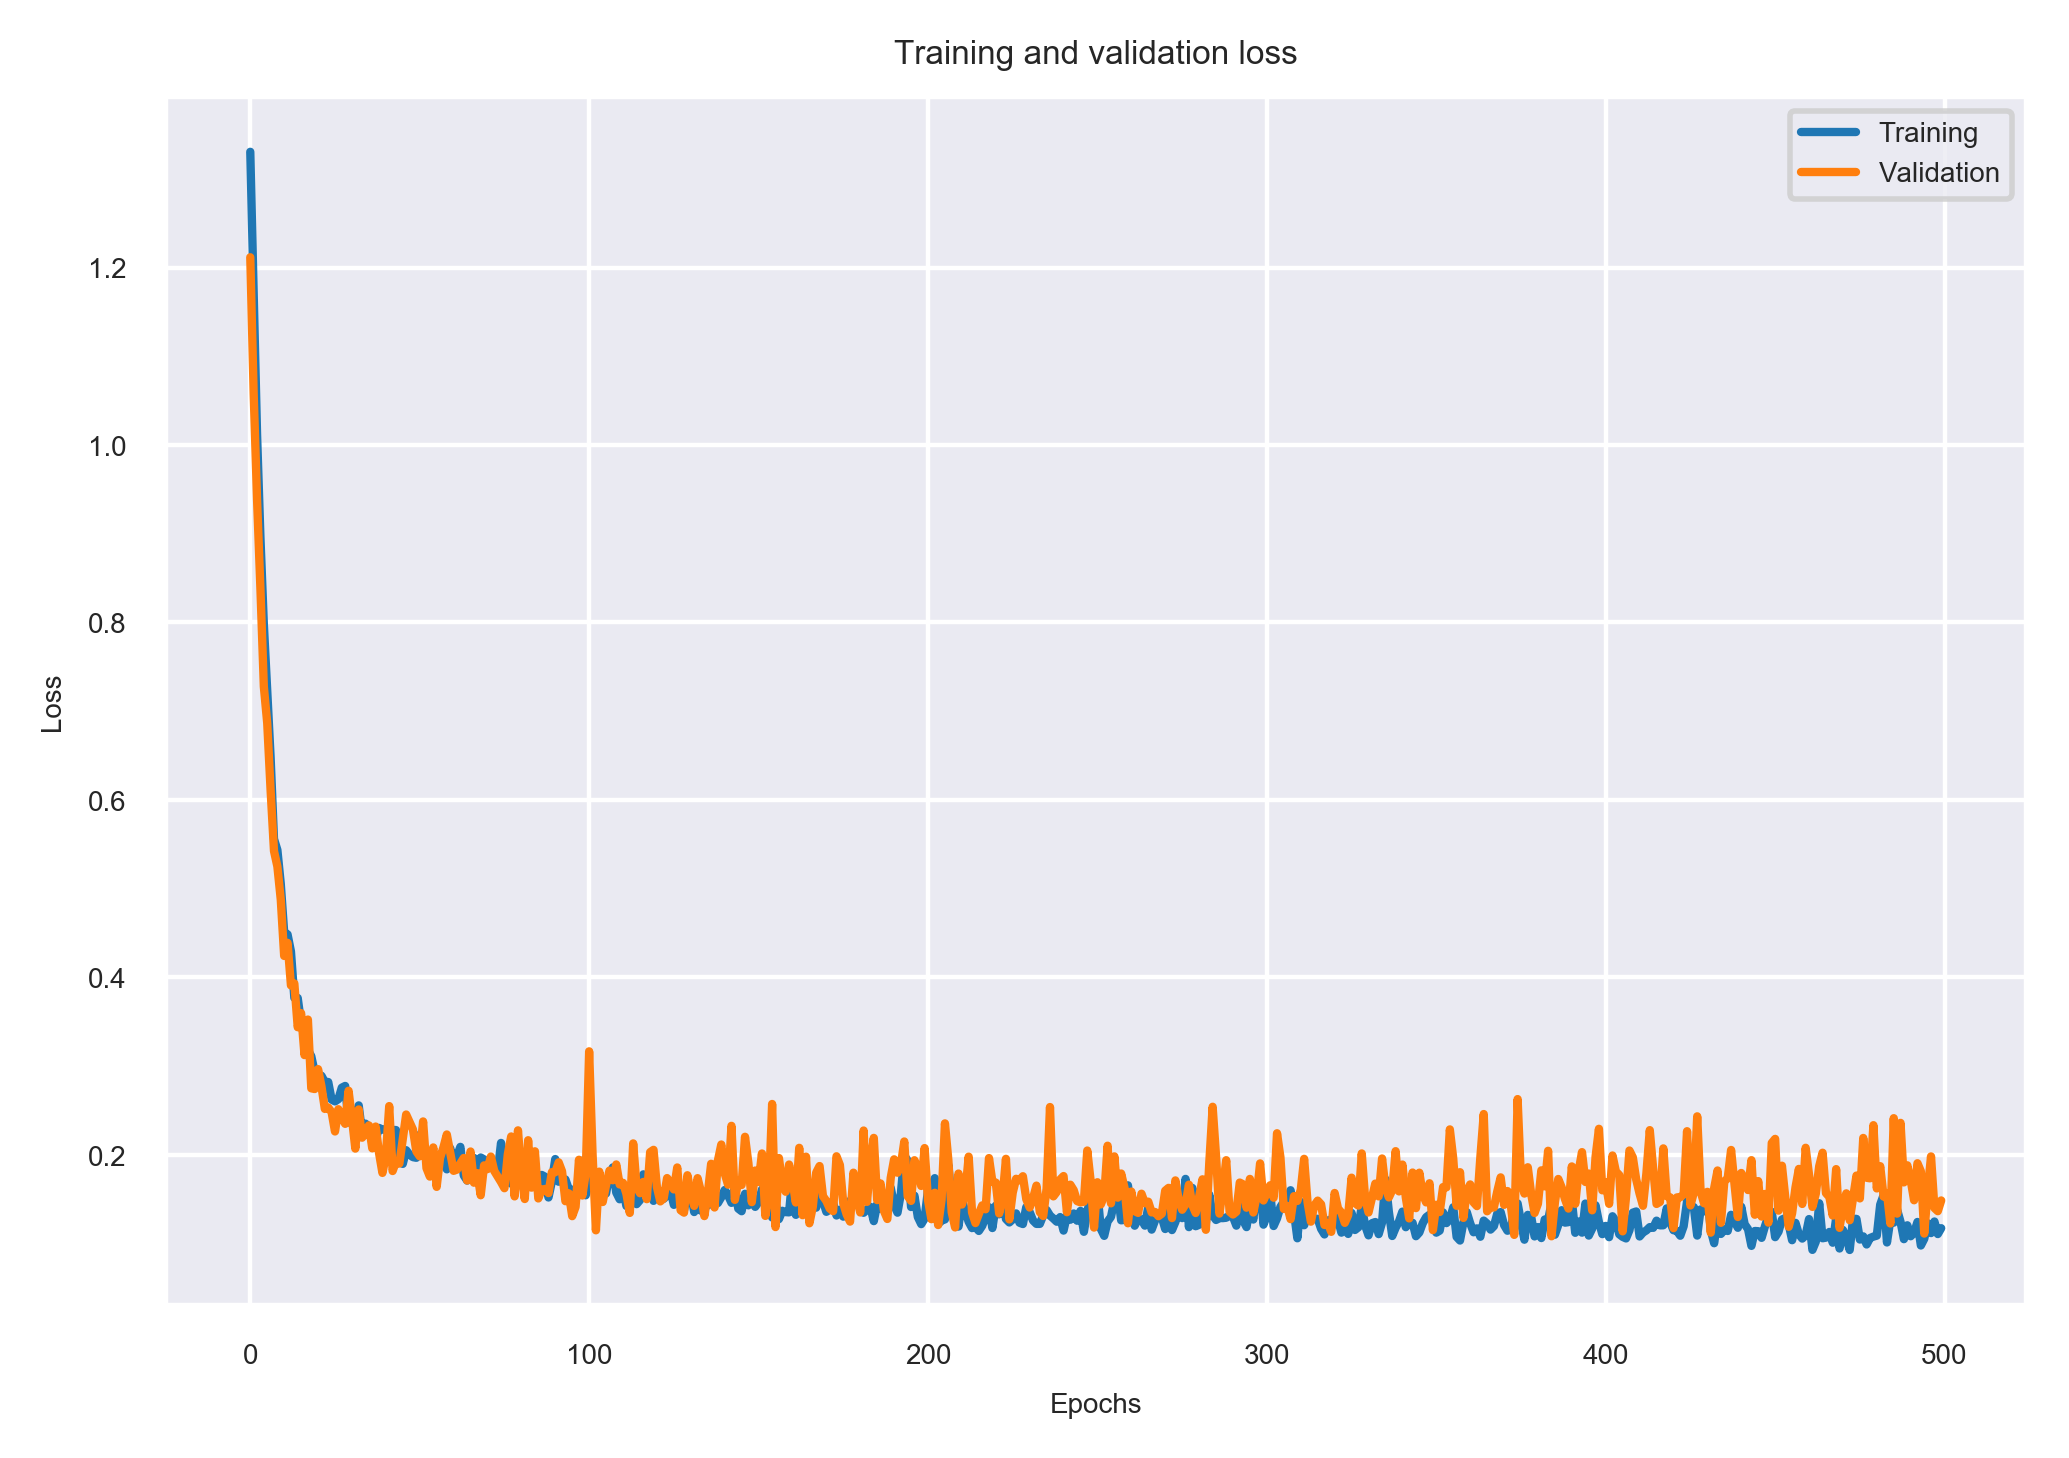

In [118]:
total_loss = torch.FloatTensor(total_loss)
sns.lineplot(x=range(len(total_loss)), y=total_loss[:,0], label = 'Training')
sns.lineplot(x=range(len(total_loss)), y=total_loss[:,1], label = 'Validation')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()

In [93]:
# torch.save(net, 'C:/YujianWu/Data/AMG/20190624_Flair/66recall.pth')

C:\Users\YWu42\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [122]:
net = torch.load('C:/YujianWu/Data/AMG/20190624_Flair/37recall.pth')

In [116]:
for i in net.state_dict().keys():
    print(net.state_dict()[i].size())

torch.Size([6, 1, 3])
torch.Size([6])
torch.Size([120, 12])
torch.Size([120])
torch.Size([4, 120])
torch.Size([4])


In [84]:
test_dataset = getData(training_dir='C:/YujianWu/Data/AMG/20190624_Flair/nn_test.csv', train=False, norm_obj=normalizer)

C:\Users\YWu42\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


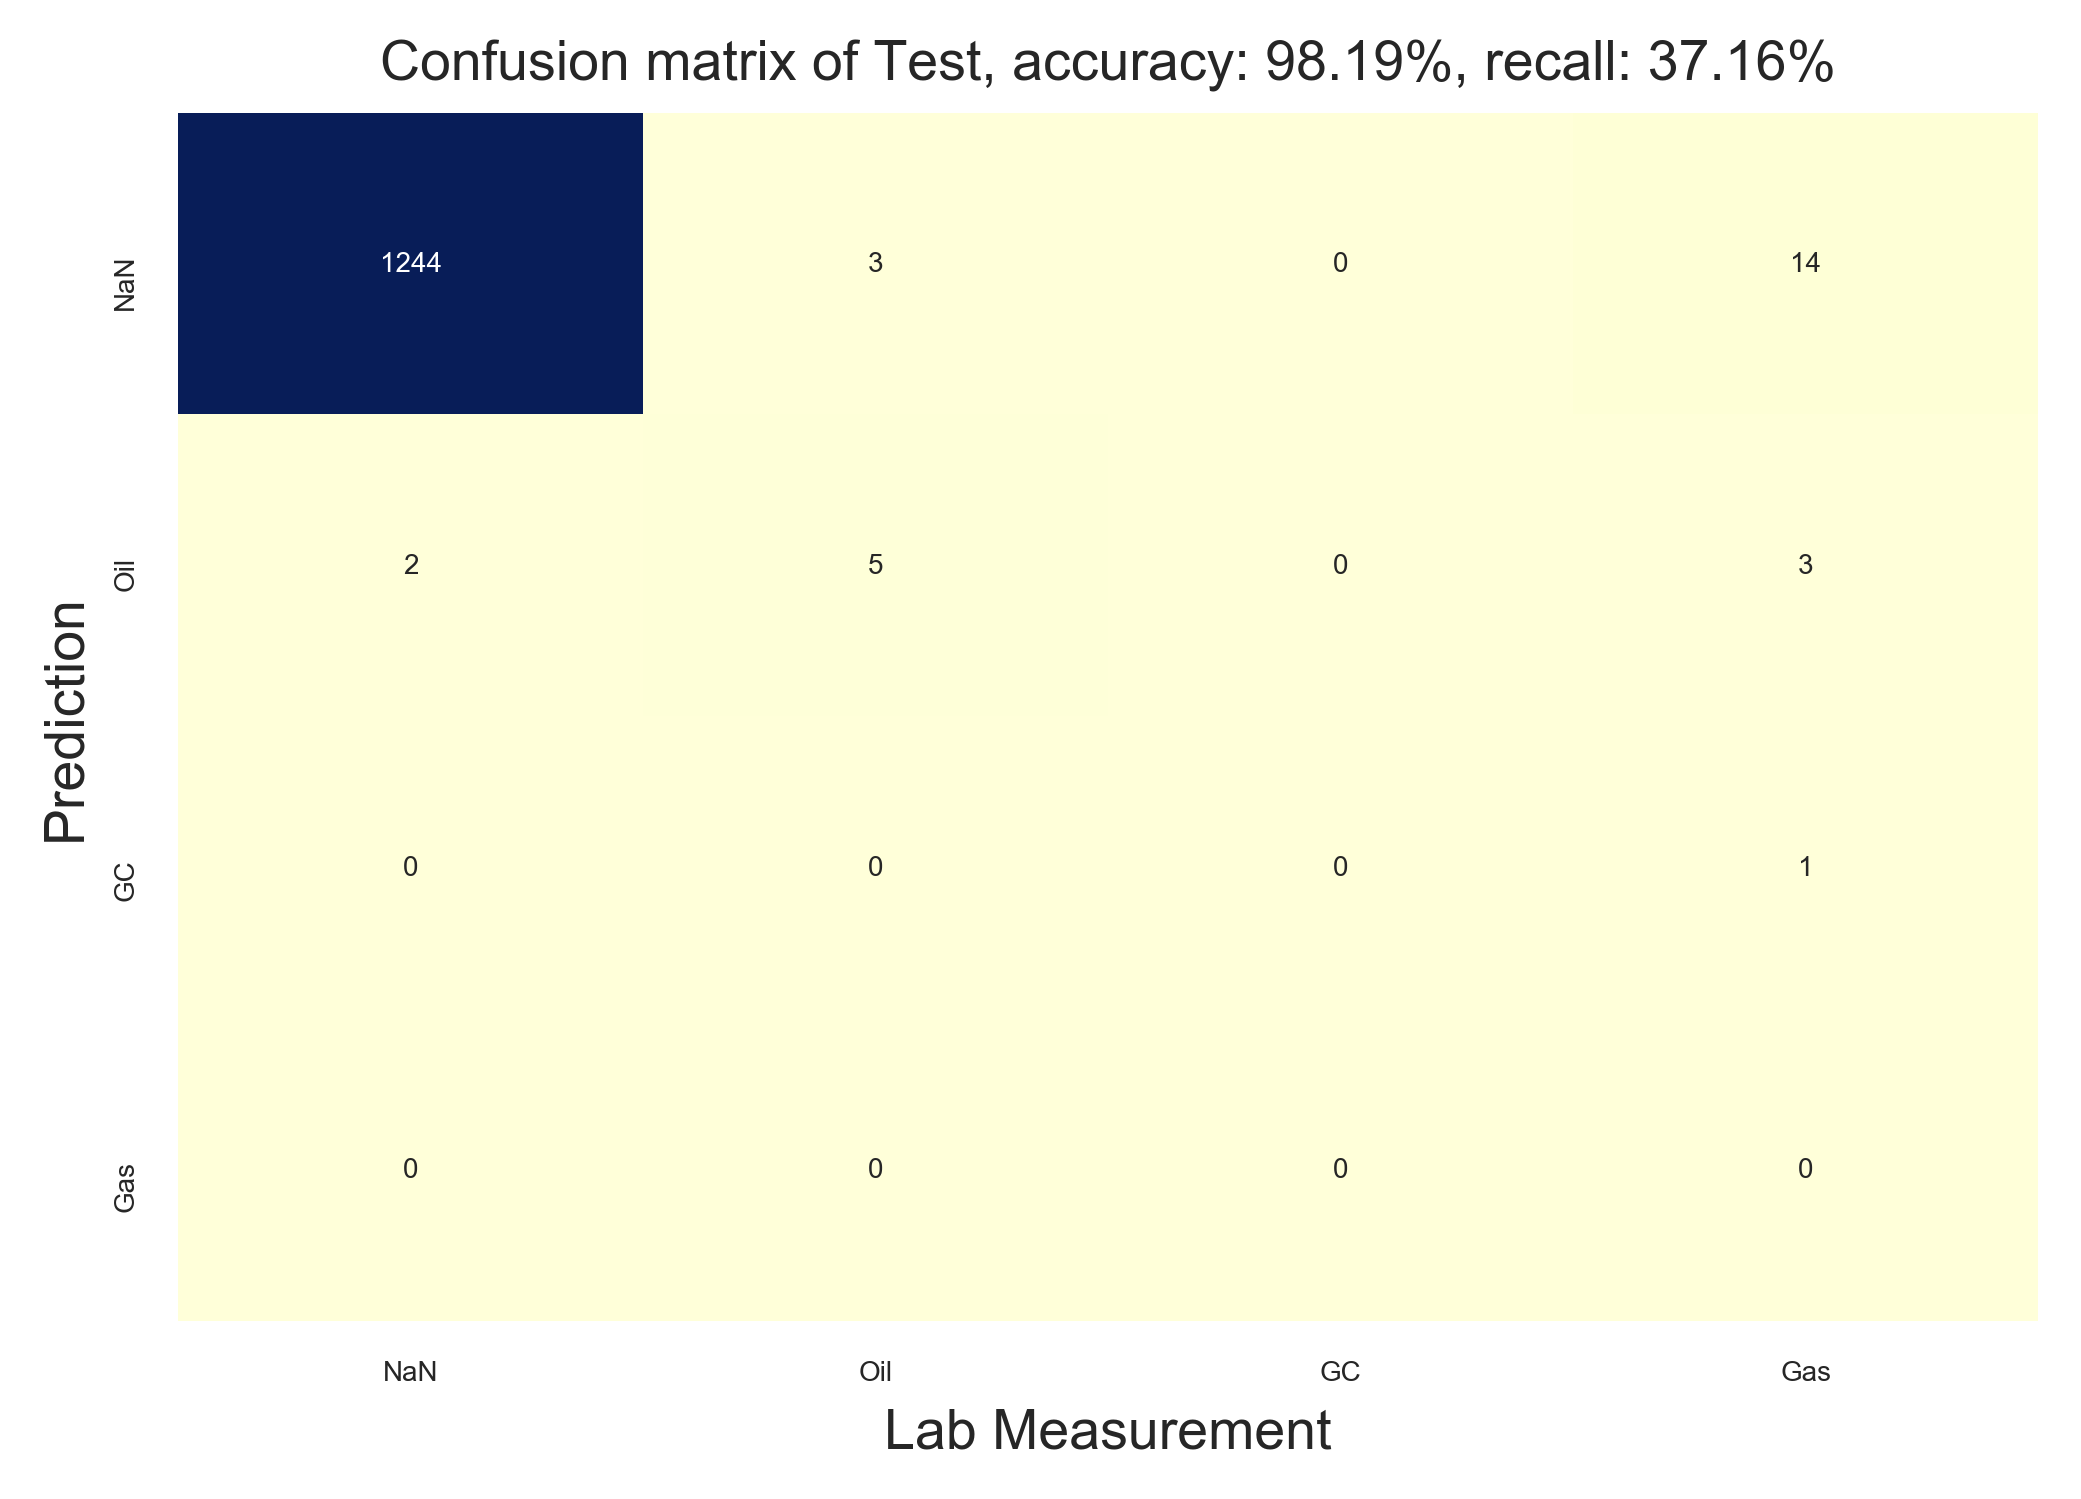

In [123]:
l3, l4 = myTest(test_dataset)
plotconfmat('Test', l3, l4)

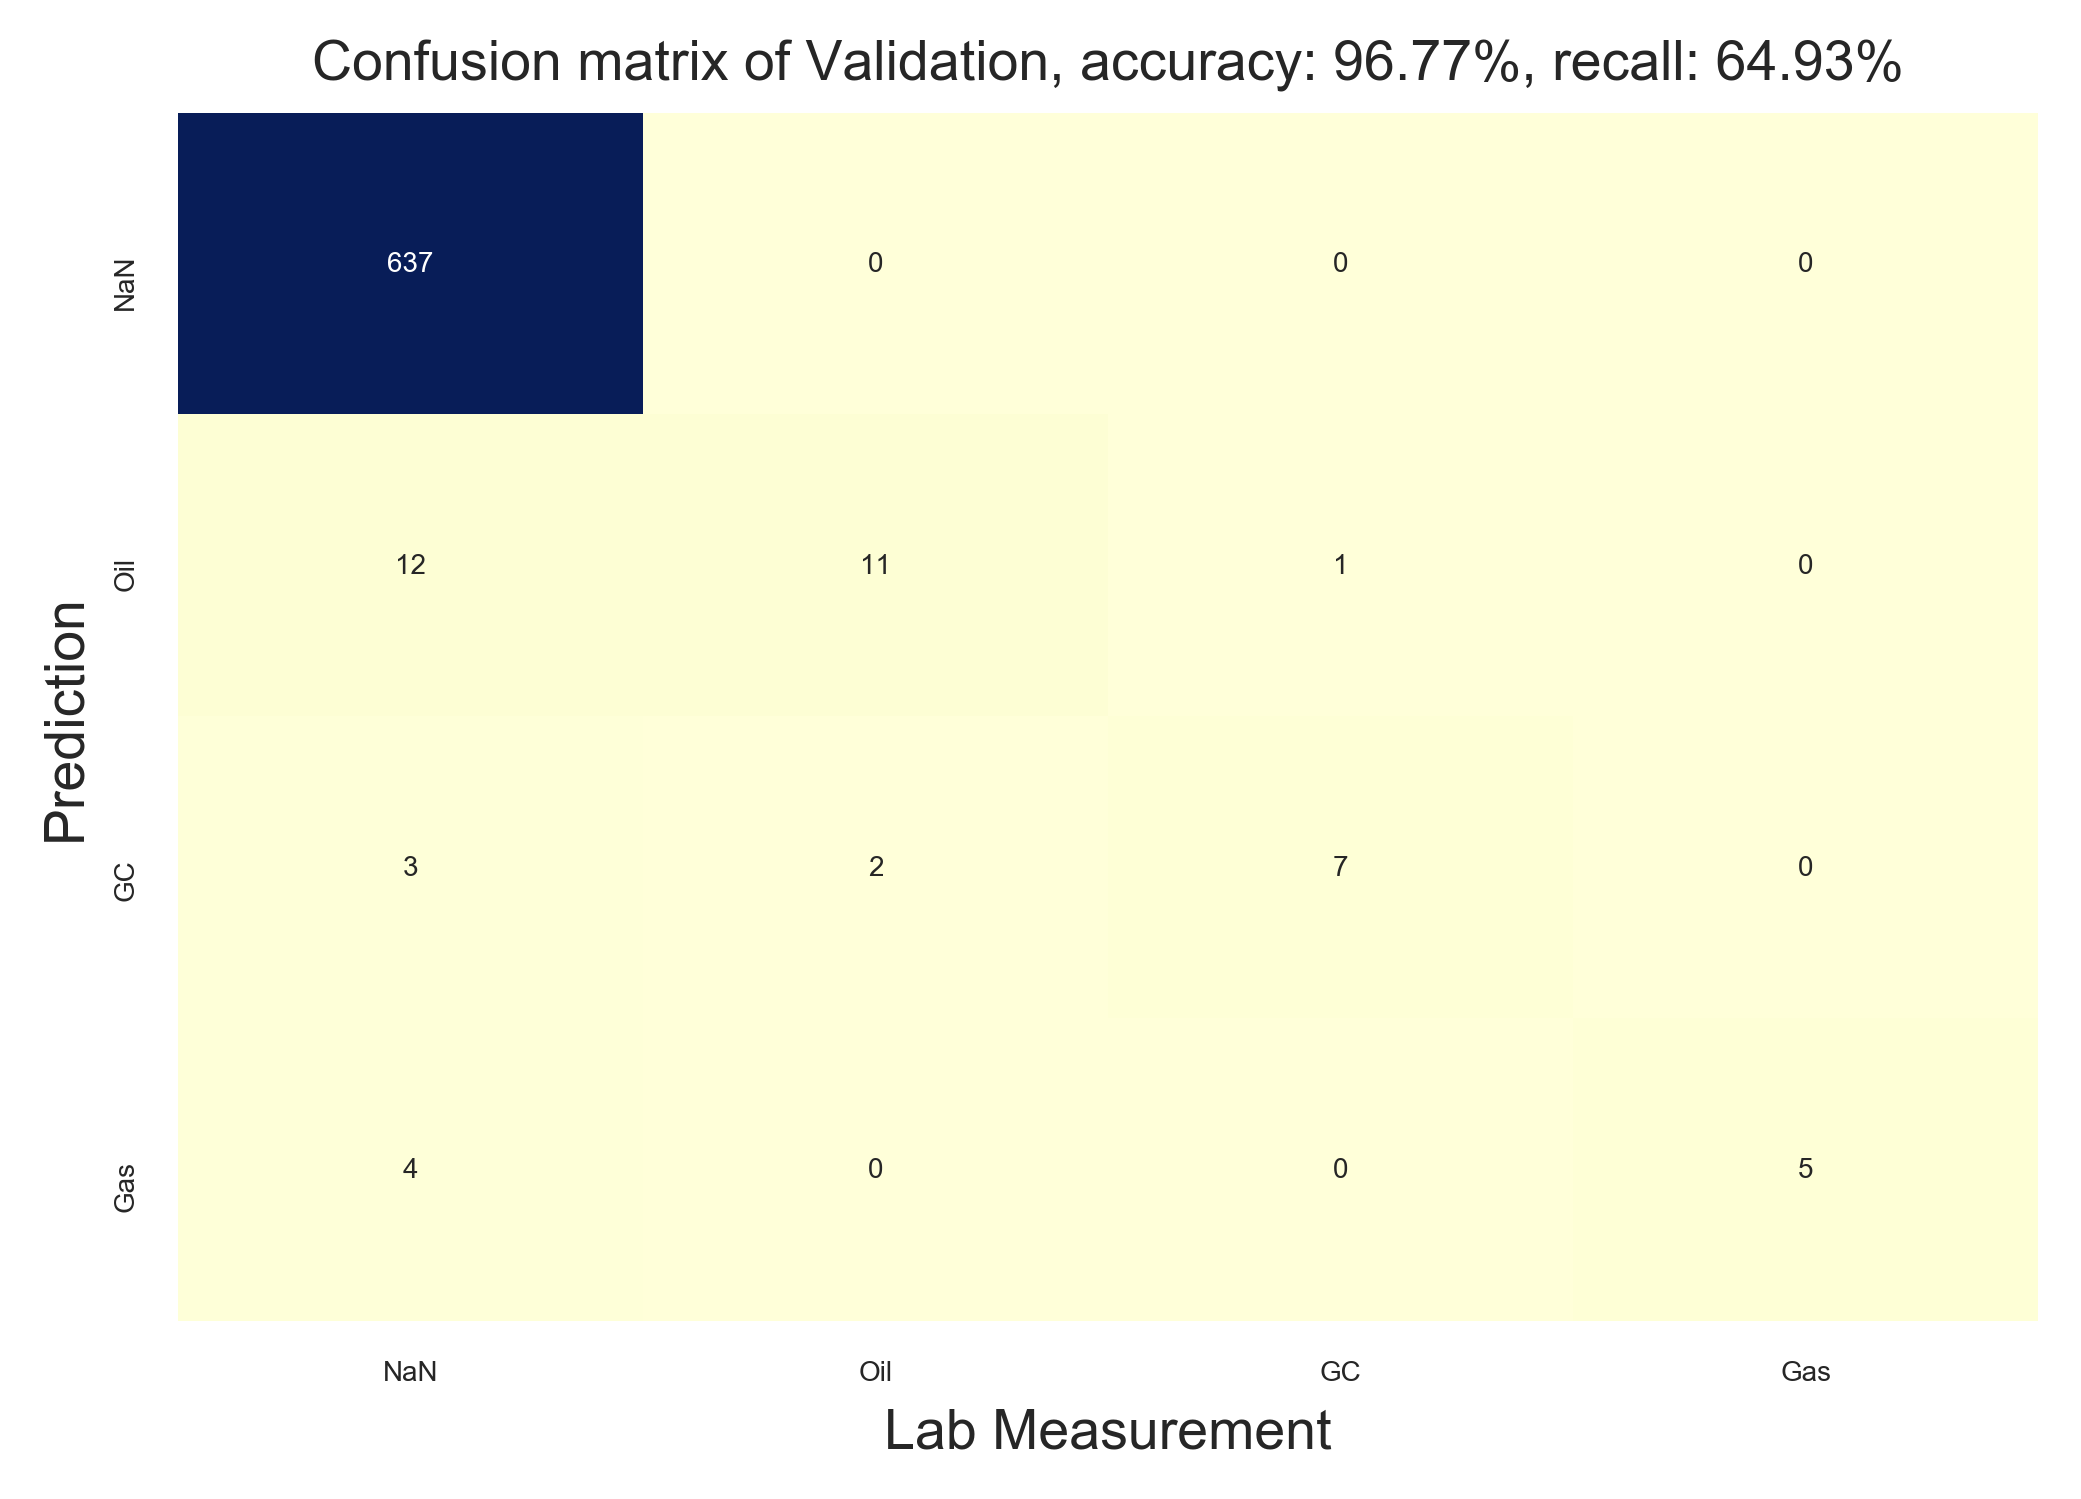

In [124]:
l1, l2 = myTest(validation_data)
plotconfmat('Validation', l1, l2)

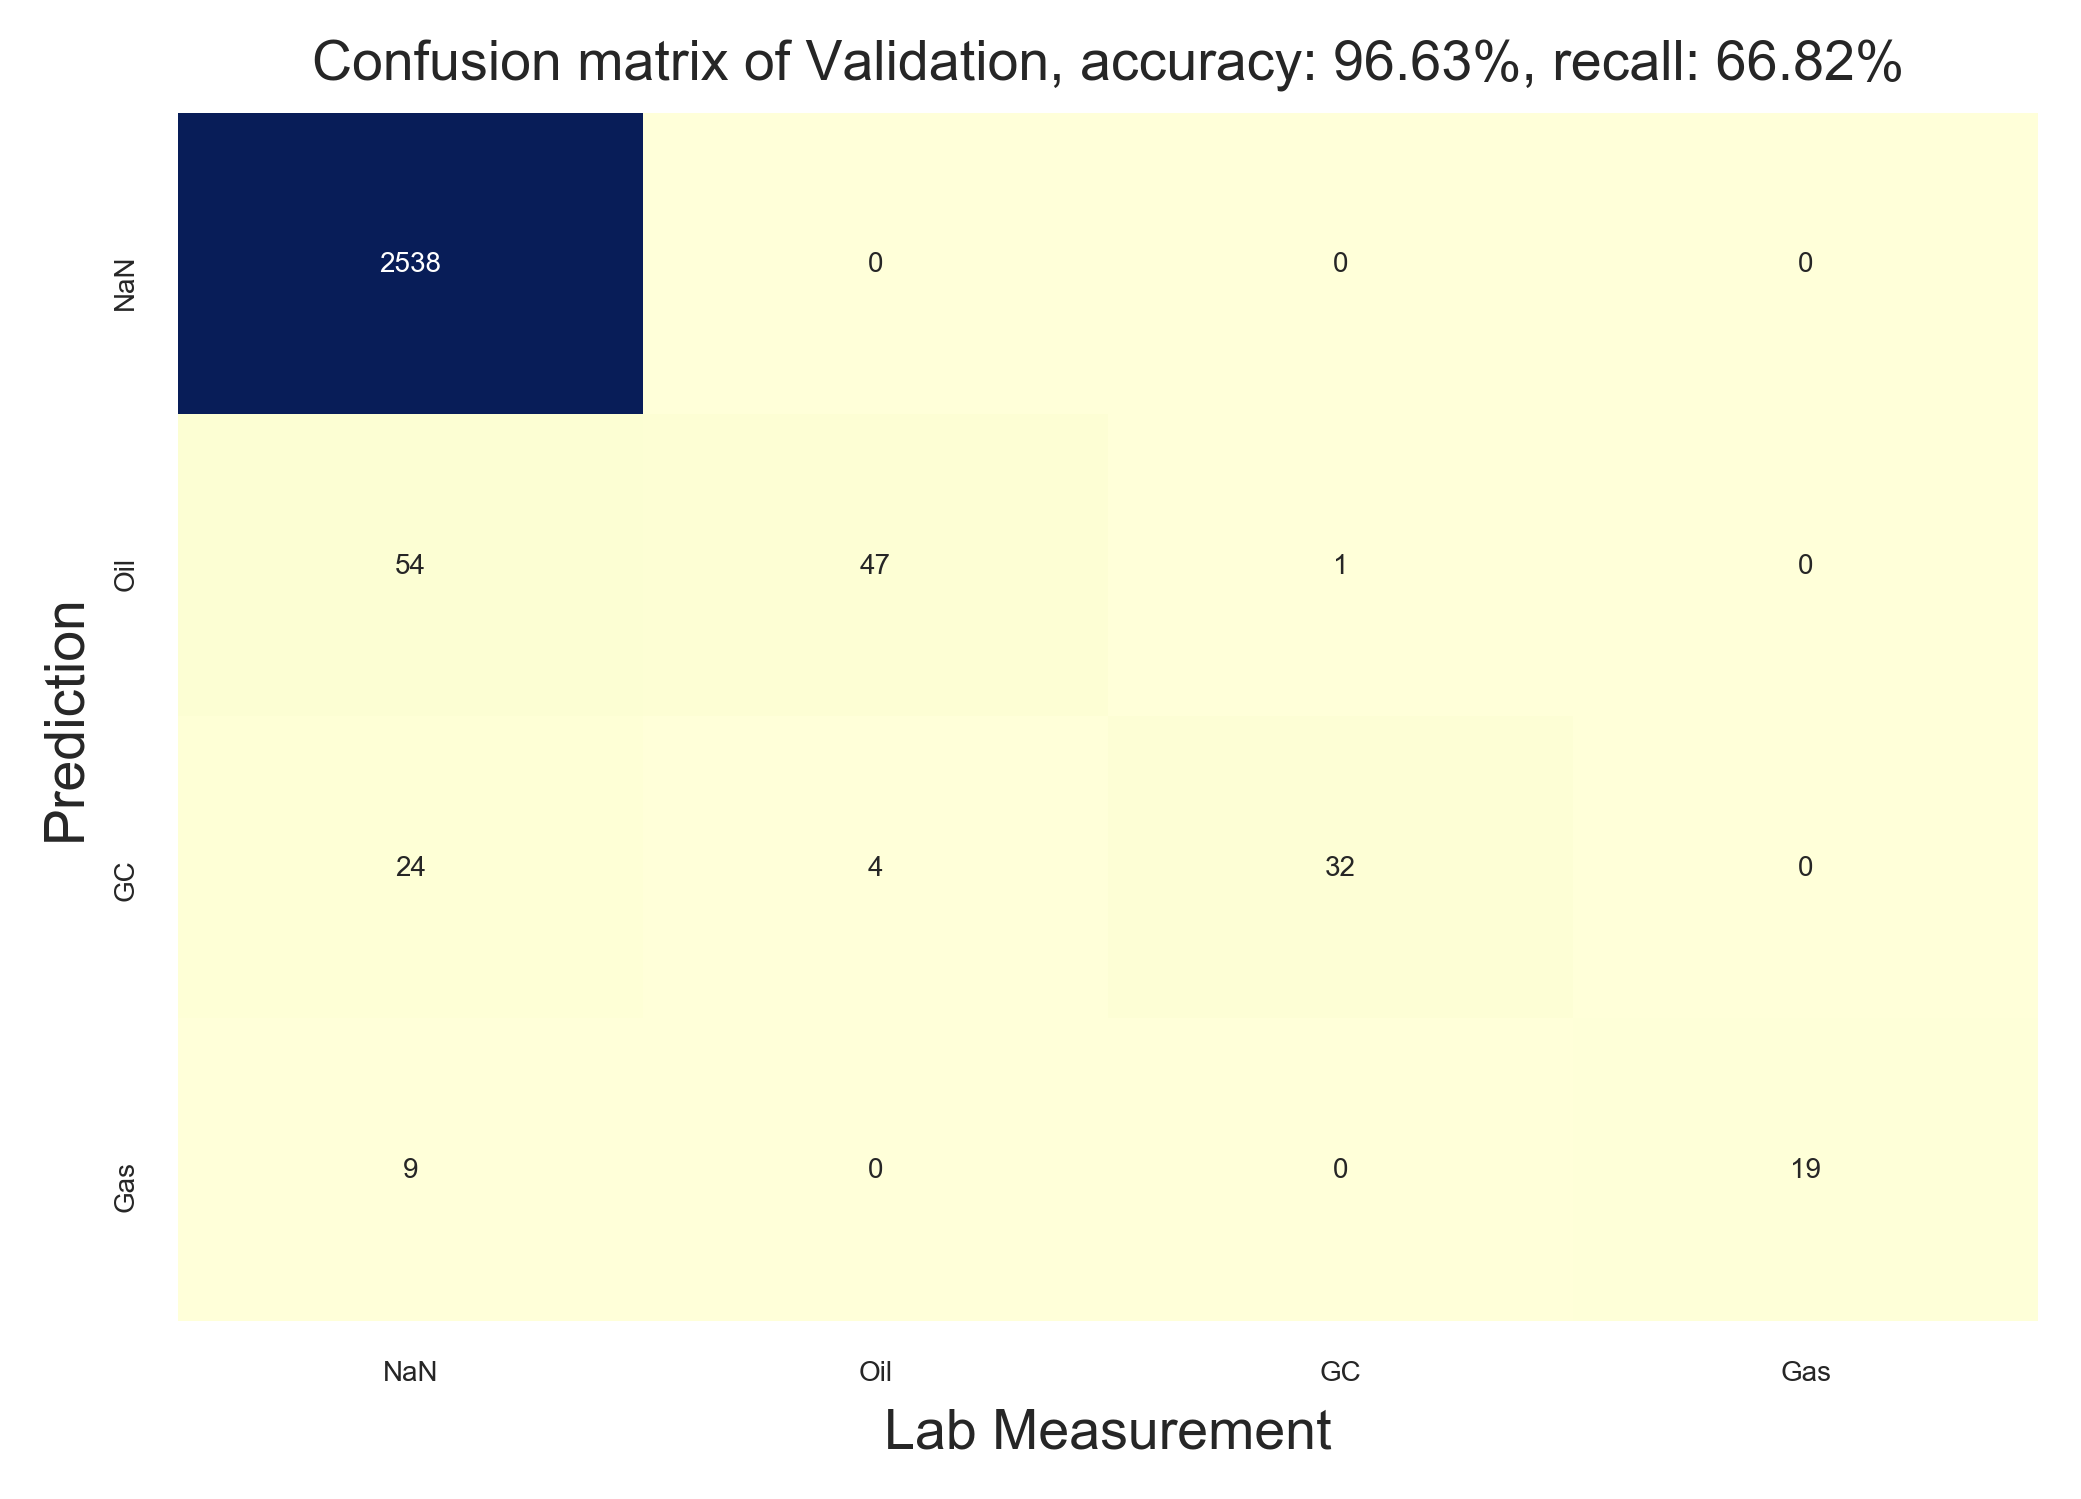

In [125]:
l1, l2 = myTest(training_data)
plotconfmat('Validation', l1, l2)